In [1]:
import numpy
import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score


In [71]:

def load_parkinsons():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data"

    # Load dataset
    df = pd.read_csv(url)
    
    # Drop name column (not useful for prediction)
    df = df.drop(columns=["name"])
    
    # Define features (X) and target (y)
    X = df.drop(columns=["status"])
    y = df["status"]  # 1 = Parkinson's, 0 = Healthy

    return X, y


# Load dataset
#data = sklearn.datasets.load_wine()
data = sklearn.datasets.load_breast_cancer()
X, y = data.data, data.target

#print(y.mean())
#X, y = load_parkinsons()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Scale the features for better performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [72]:
def exp_range(start, end, mul):
    while start < end:
        yield start
        start *= mul

trees = [ int(d) for d in exp_range(2, 120, 1.5) ]
list(trees)

[2, 3, 4, 6, 10, 15, 22, 34, 51, 76, 115]

In [73]:
# Define parameter ranges
n_trees = trees # numpy.arange(1, 100+1, 4)  # Number of trees
max_depths = numpy.arange(1, 10+1)  # Maximum depth

# Store accuracy values
performance = np.zeros((len(n_trees), len(max_depths)))

# Train models and evaluate performance
results = []
for i, n in enumerate(n_trees):
    for j, d in enumerate(max_depths):
        scores = []
        for t in range(0, 5):
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=42)
            rf.fit(X_train, y_train)
            y_pred_test = rf.predict(X_test)
            y_pred_train = rf.predict(X_train)
            train_score = 100 * (1.0 - f1_score(y_train, y_pred_train, average='micro'))
            test_score = 100 * (1.0 - f1_score(y_test, y_pred_test, average='micro'))
            results.append((n, d, t, test_score, train_score))

results = pandas.DataFrame(results, columns=['trees', 'depth', 'trial', 'test_score', 'train_score'])
results

,trees,depth,trial,test_score,train_score
0,2,1,0,9.356725,7.788945
1,2,1,1,9.356725,7.788945
2,2,1,2,9.356725,7.788945
3,2,1,3,9.356725,7.788945
4,2,1,4,9.356725,7.788945
...,...,...,...,...,...
545,115,10,0,6.432749,0.000000
546,115,10,1,6.432749,0.000000
547,115,10,2,6.432749,0.000000
548,115,10,3,6.432749,0.000000


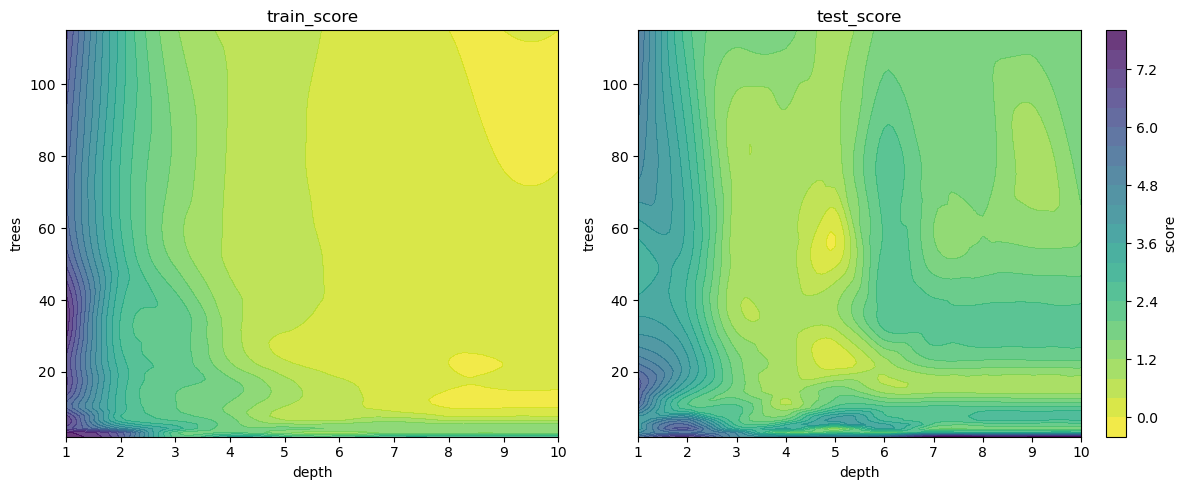

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [74]:
# Create contour plot

def plot_results(ax, results : pandas.DataFrame,
                 x='depth',
                 y='trees',
                 score='train_score',
                 resolution=100,
                 cmap="viridis_r",
                 vmin=None,
                 vmax=None,
                 levels=20,
                ):
    
    from scipy.interpolate import griddata
    plt.figure(figsize=(8, 6))
    
    r = results.drop(columns=['trial']).groupby([x, y]).mean().reset_index()
    
    grid_x, grid_y = np.meshgrid(np.linspace(results[x].min(), results[x].max(), resolution),
                                 np.linspace(results[y].min(), results[y].max(), resolution))
    grid_z = griddata((r[x], r[y]), r[score], (grid_x, grid_y), method='cubic')
    
    # Plot contours
    #cmap = 
    contour = ax.contourf(grid_x, grid_y, grid_z, cmap=cmap, alpha=0.8, levels=levels)

    ax.set_title(score)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    
    #plt.title("Random Forest Accuracy Contour Plot")
    show_points = False
    if show_points:
        plt.scatter(results[x], results[y], c=results[score],
                    cmap=cmap,
                    edgecolors='black'
                   )  # Data points
    return contour
    


fig, axs = plt.subplots(1, 2, figsize=(12, 5))
common_kwargs = dict(vmin=0, vmax=30)
contour0 = plot_results(axs[0], results, score='train_score', **common_kwargs)
contour1 = plot_results(axs[1], results, score='test_score', **common_kwargs)
cbar = fig.colorbar(contour0, ax=axs[1], orientation="vertical", fraction=0.05, pad=0.05)
cbar.set_label("score")
fig.tight_layout()
fig.savefig('randomforest-distrib-cancer.png')